In [1]:
import pandas as pd
import requests
from datetime import datetime
from math import ceil
from urllib.parse import urlencode
import plotly.express as px
import aiohttp
import asyncio
import nest_asyncio

In [54]:
# Consultar contratações com recebimento de propostas em aberto
codigos = pd.read_csv('Códigos_UF_municipios.csv', sep=';')
codigos
coordenadas = pd.read_csv('lat-long-municipios.csv', sep=',')
coordenadas.head()

,municipio,latitude,longitude
0,Abadia de Goiás,-16.75730,-49.4412
1,Abadia dos Dourados,-18.48310,-47.3916
2,Abadiânia,-16.19700,-48.7057
3,Abaeté,-19.15510,-45.4444
4,Abaetetuba,-1.72183,-48.8788


In [55]:
municipio_lat_long = pd.merge(coordenadas,codigos, left_on = coordenadas['municipio'].str.lower(), right_on =codigos['Nome_Município'].str.lower() , how ='left')
municipio_lat_long = municipio_lat_long[['Nome_UF','UF', 'municipio','Código_Município_Completo', 'latitude', 'longitude']]
municipio_lat_long.sort_values(by='municipio')
municipio_lat_long.head(10)

,Nome_UF,UF,municipio,Código_Município_Completo,latitude,longitude
0,Goiás,52.0,Abadia de Goiás,5200050.0,-16.75730,-49.4412
1,Minas Gerais,31.0,Abadia dos Dourados,3100104.0,-18.48310,-47.3916
2,Goiás,52.0,Abadiânia,5200100.0,-16.19700,-48.7057
3,Minas Gerais,31.0,Abaeté,3100203.0,-19.15510,-45.4444
4,Pará,15.0,Abaetetuba,1500107.0,-1.72183,-48.8788
5,Ceará,23.0,Abaiara,2300101.0,-7.34588,-39.0416
6,Bahia,29.0,Abaíra,2900108.0,-13.24880,-41.6619
7,Bahia,29.0,Abaré,2900207.0,-8.72073,-39.1162
8,Paraná,41.0,Abatiá,4100103.0,-23.30490,-50.3133
9,Santa Catarina,42.0,Abdon Batista,4200051.0,-27.61260,-51.0233


In [56]:
#Pesquisando latitude e longitude por municipio

municipio_lat_long.query("municipio=='Itamogi'").latitude
municipio_lat_long.query("municipio=='Itamogi'").longitude


2591   -47.046
Name: longitude, dtype: float64

In [121]:
def request_editais(editais_params):

    codigoModalidadeContratacao = None
    uf = None
    municipio = None
    cnpj = None
    codigoUnidadeAdministrativa = None
    idUsuario = None
    tamanhoPagina = None

    #payload = {'dataFinal': str(int(datetime.now().strftime('%Y%m%d'))+1), 'codigoModalidadeContratacao': codigoModalidadeContratacao, 'uf': uf,
    #           'codigoMunicipioIbge': municipio, 'cnpj': cnpj, 'codigoUnidadeAdministrativa': codigoUnidadeAdministrativa,
    #           'idUsuario': idUsuario, 'pagina': 1, 'tamanhoPagina': 50}
    #parametros = {key: payload[key] for key in payload.keys() & {'dataFinal', 'pagina', 'tamanhoPagina'}}

    r = requests.get('https://pncp.gov.br/api/search/', params=editais_params)
    return r

async def fetch_multiple(urls):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch(session, url) for url in urls]
        responses = await asyncio.gather(*tasks)
    return responses

async def fetch(session, url):
    async with session.get(url) as response:
        return await response.json()

async def main(urls):
    item =[]
    urls = urls
    responses = await fetch_multiple(urls)
    for response in responses:
        item.append(response)
    return item

### Realizando a pesquisa desejada

In [122]:
params_editais = {
        'tipos_documento': 'edital',
        'ordenacao': '-data',
        'pagina': '1',
        'tam_pagina': '10',
        'status': 'recebendo_proposta',
        #'municipios': 4359
    }

r = request_editais(params_editais)

total_items = r.json()['total']
total_paginas = ceil(total_items/int(params_editais['tam_pagina']))
total_paginas

4

## Vamos ver o que temos na resposta e separar o que nos interessa

### De acordo com a requisição XHR obtida do site do PNCP temos os seguintes elementos na resposta:

<img src="print-XHR-PNCP.jpg" width="600" alt="print-XHR-PNCP"/>
<img src="print-XHR-PNCP-2.jpg" width="600" alt="print-XHR-PNCP"/>

### Alguns items serão coletados para possibilitar a busca posterior dos itens constantes em cada edital, enquanto outros serão coletados para a visualização dos dados.

### Necessários para a busca dos itens:

- orgao_cnpj;
- ano;
- numero_sequencial;
### Para visualização dos dados:

- municipio_nome;
- esfera_nome;
- uf;
- orgao_nome;
- description;
- valor_global;
- modalidade_licitacao_nome;
- data_inicio_vigencia;
- data_fim_vigencia;
- ano;


#### Coleta de editais na busca realizada

In [ ]:

editais = []
df_editais = pd.DataFrame()

for pagina in range(1,total_paginas + 1):
    
    params_editais['pagina'] = pagina
    registros_editais = pd.json_normalize(request_editais(params_editais).json()['items'])[['municipio_nome','esfera_nome', 'uf', 'orgao_nome', 'orgao_cnpj' ,'description', 'modalidade_licitacao_nome',
                                              'data_inicio_vigencia', 'data_fim_vigencia', 'ano', 'numero_sequencial']]
    editais.append(registros_editais)

df_editais = pd.concat(editais, ignore_index=True)
df_editais.rename(columns = {'numero_sequencial':'Numero_Sequencial', 'municipio_nome':'Municipio', 'esfera_nome':'Esfera', 'orgao_nome':'Orgao', 'orgao_cnpj':'Orgao_CNPJ', 'description':'Descricao',
                              'modalidade_licitacao_nome':'Modalidade', 'data_inicio_vigencia':'Data_Inicio',
                                'data_fim_vigencia':'Data_Fim', 'ano':'Ano'}, inplace = True)
df_editais.head()

### Uma das coisas mais importantes para quem pesquisa no portal é conseguir ver quais items estão sendo licitados por edital sem ter que abrir cada um.
#### Por exemplo, seria interessante termos uma tabela indicando diretamente quais itens e os valores que estão sendo pedidos por edital.

In [ ]:
editais = []
items = []
df_editais = pd.DataFrame()
df_items = pd.DataFrame()

params_items = {
    'páginas': 1,
    'tamanhoPagina': 10
}

for pagina in range(1,total_paginas + 1):
    
    params_editais['pagina'] = pagina
    registros_editais = pd.json_normalize(request_editais(params_editais).json()['items'])[['municipio_nome','esfera_nome', 'uf', 'orgao_nome', 'orgao_cnpj' ,'description', 'modalidade_licitacao_nome',
                                              'data_inicio_vigencia', 'data_fim_vigencia', 'ano', 'numero_sequencial']]
    editais.append(registros_editais)
    for edital in range(len(registros_editais)):
        orgao_cnpj = registros_editais['orgao_cnpj'][edital] #Colocar o numerp da linha do df_editais
        ano_url = registros_editais['ano'][edital] # conferir para ver se realmente o ano que consta na url
        numero_sequencial = registros_editais['numero_sequencial'][edital]

        items_qtd = requests.get('https://pncp.gov.br/api/pncp/v1/orgaos/' + orgao_cnpj + '/compras/' + ano_url + '/' + numero_sequencial +'/itens/quantidade').json()
        total_paginas_items = ceil(items_qtd / params_items['tamanhoPagina'])
    
        for pagina_item in range(1,total_paginas_items + 1):

            params_items['páginas'] = pagina_item

            r_items = requests.get('https://pncp.gov.br/api/pncp/v1/orgaos/' + orgao_cnpj +'/compras/' + ano_url + '/' +  numero_sequencial + '/itens?', params=params_items)

            registro_items = pd.json_normalize(r_items.json()) \
                [['descricao', 'materialOuServicoNome', 'quantidade', 'unidadeMedida', 'valorUnitarioEstimado', 'valorTotal', 'orcamentoSigiloso', 'tipoBeneficioNome']]
            registro_items['Numero_Sequencial'] = numero_sequencial
            registro_items['Orgao_CNPJ'] = orgao_cnpj
            registro_items['Ano'] = ano_url

            items.append(registro_items)
    
df_items = pd.concat(items, ignore_index=True)
df_items.rename(columns = {'descricao':'Descricao_Item','materialOuServicoNome':'Tipo','quantidade':'Qtd','unidadeMedida':'Un. Medida',
                            'valorUnitarioEstimado':'Valor_Unit.', 'valorTotal':'Valor_Total', 'orcamentoSigiloso':'Sigiloso',
                            'tipoBeneficioNome':'Tipo_Beneficio'}, inplace = True)


df_editais = pd.concat(editais, ignore_index=True)
df_editais.rename(columns = {'numero_sequencial':'Numero_Sequencial', 'municipio_nome':'Municipio', 'esfera_nome':'Esfera', 'orgao_nome':'Orgao', 'orgao_cnpj':'Orgao_CNPJ', 'description':'Descricao',
                              'modalidade_licitacao_nome':'Modalidade', 'data_inicio_vigencia':'Data_Inicio',
                                'data_fim_vigencia':'Data_Fim', 'ano':'Ano', 'uf': 'UF'}, inplace = True)


df_compilado = df_items.merge(df_editais, left_on=['Ano', 'Numero_Sequencial', 'Orgao_CNPJ'], right_on=['Ano', 'Numero_Sequencial', 'Orgao_CNPJ'])
df_compilado.set_index(['Ano', 'Numero_Sequencial', 'Orgao_CNPJ'])


# Testando request paralelizado

In [ ]:
links_editais = []
lista_editais = []
df_editais = pd.DataFrame()

params_editais = {
        'tipos_documento': 'edital',
        'ordenacao': '-data',
        'pagina': '1',
        'tam_pagina': '10',
        'status': 'recebendo_proposta',
        #'municipios': None
    }

r = request_editais(params_editais)

total_items = r.json()['total']
total_paginas = ceil(total_items/int(params_editais['tam_pagina']))
total_paginas

url_base = 'https://pncp.gov.br/api/search/?'


for pagina in range(1,total_paginas + 1):
    
    params_editais['pagina'] = pagina
    links_editais.append(url_base +  urlencode(params_editais))
    
editais = loop.run_until_complete(main(links_editais))

for i in range(1000): #limitado pelo numero de páginas suportados no site de 999
  lista_editais.append(editais[i]['items'])

lista_df_editais = [pd.json_normalize(lista_editais[i]) for i in range(len(lista_editais))]
df_editais = pd.concat(lista_df_editais, ignore_index=True)
df_editais

In [ ]:
links_total_items_edital = ['https://pncp.gov.br/api/pncp/v1/orgaos/'+ url.split('/')[2] + '/compras/' + url.split('/')[3] + '/' + url.split('/')[4] + '/itens/quantidade' for url in df_editais['item_url']]

In [ ]:
links_total_items_edital

In [ ]:
nest_asyncio.apply()
loop = asyncio.get_event_loop()

total_items_edital = loop.run_until_complete(main(links_total_items_edital))
total_items_edital

In [ ]:
params_items = {
    'páginas': '1',
    'tamanhoPagina': '10'
}

link_itens_edital = []
paginas_items_edital = [ceil(int(x) / int(params_items['tamanhoPagina'])) for x in total_items_edital]
for item in range(len(links_total_items_edital)):
  if paginas_items_edital[item] > 1:
    link = [links_total_items_edital[item-1][:-11] + '?pagina=' + str(i) + '&tamanhoPagina=' + params_items['tamanhoPagina'] for i in range(1,paginas_items_edital[item] +1)]
    link_itens_edital.extend(link)
  else: link_itens_edital.append(links_total_items_edital[item-1][:-11] + '?pagina=' + str(1) + '&tamanhoPagina=' + params_items['tamanhoPagina'])

In [ ]:
link_itens_edital

In [ ]:
total_items_todos_edital = loop.run_until_complete(main(link_itens_edital))
total_items_todos_edital

In [ ]:
df=pd.DataFrame()
for i in range(len(total_items_todos_edital)):
  
  df = pd.concat([df, pd.json_normalize(total_items_todos_edital[i])], ignore_index=True)
df.unstack()
df

In [ ]:
params_editais = {
        'tipos_documento': 'edital',
        'ordenacao': '-data',
        'pagina': '1',
        'tam_pagina': '10',
        'status': 'recebendo_proposta',
        'municipios': None
    }

filters = request_editais(params_editais).json()['filters']
columns = pd.json_normalize(request_editais(params_editais).json()['filters']).columns
df_filters = []


for column in columns:
  df_filters.append(pd.json_normalize(filters[column]))

df_filters[5]

## Vamos extrair alguns dados da página inicial do PNCP sem filtros

In [76]:
import matplotlib

headers = {
    'authority': 'pncp.gov.br',
    'accept': 'application/json, text/plain, */*'
}

params = {
    'tipos_documento': 'edital',
    'ordenacao': '-data',
    'pagina': '1',
    'tam_pagina': '10',
    'status': 'recebendo_proposta',
}

r = requests.get('https://pncp.gov.br/api/search/', params=params, headers=headers)
data = r.json()

In [77]:
licit_anos = pd.DataFrame(data['filters']['anos'])
licit_esferas = pd.DataFrame(data['filters']['esferas'])[['nome', 'total']]
licit_modalidades = pd.DataFrame(data['filters']['modalidades'])
licit_municipios = pd.DataFrame(data['filters']['municipios'])[['nome', 'total']]
licit_orgaos = pd.DataFrame(data['filters']['orgaos'])
licit_poderes = pd.DataFrame(data['filters']['poderes'])
licit_tipo = pd.DataFrame(data['filters']['tipos'])
licit_ufs = pd.DataFrame(data['filters']['ufs'])
licit_unidades = pd.DataFrame(data['filters']['unidades'])[['nome', 'total']]

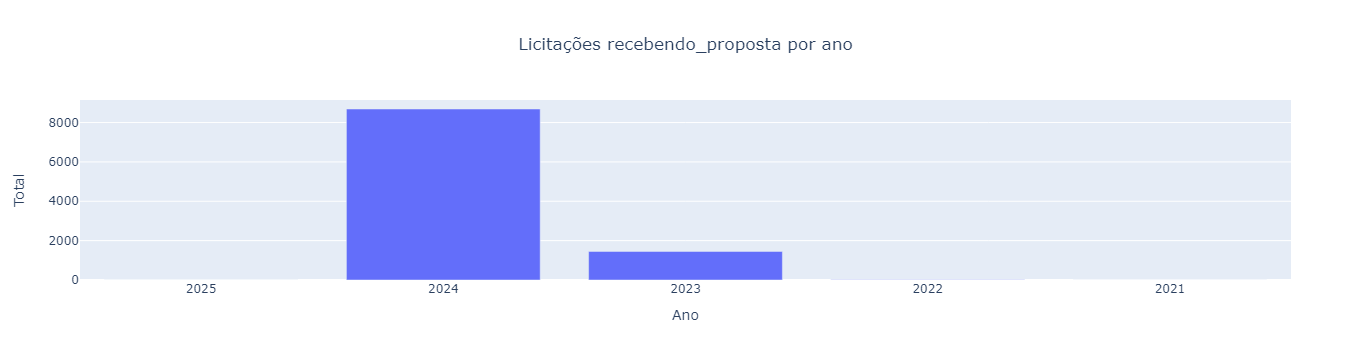

In [78]:

fig = px.bar(licit_anos, title='Licitações ' + params['status'] + ' por ano', x='ano', y='total')
fig.update_layout(title_x=0.5, xaxis_title='Ano', yaxis_title='Total')
fig.show()


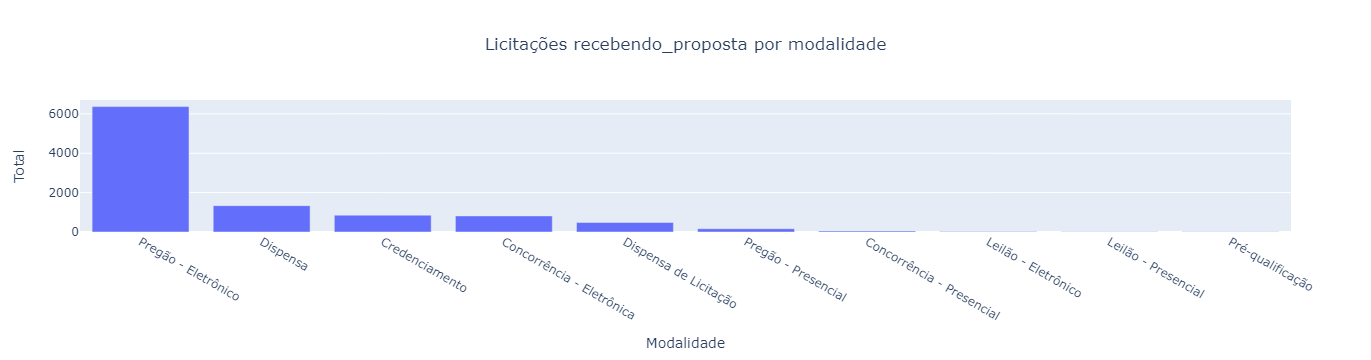

In [79]:
fig =px.bar(licit_modalidades, title='Licitações ' + params['status'] + ' por modalidade', x='nome', y='total')
fig.update_layout(title_x=0.5, xaxis_title='Modalidade', yaxis_title='Total')
fig.show()

In [ ]:
#Colocar bubble map com licitações por município

# Create Scattermapbox trace
trace = go.Scattermapbox(
    lat=coordenadas['latitude'],
    lon=coordenadas['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=df['bids'],  # You can adjust size based on bids or any other attribute
        color=df['bids'],  # You can choose any column to define colors
        colorscale='Viridis',  # You can choose any colorscale
        cmin=0,
        cmax=df['bids'].max(),
        colorbar=dict(title='Bids')
    ),
    text=coordenadas['municipio']
)

# Create layout
layout = go.Layout(
    title='Bids by City',
    hovermode='closest',
    mapbox=dict(
        accesstoken='YOUR_MAPBOX_TOKEN',  # Replace with your Mapbox access token
        bearing=0,
        center=dict(
            lat=coordenadas['latitude'].mean(),
            lon=coordenadas['longitude'].mean()
        ),
        pitch=0,
        zoom=5
    )
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

In [ ]:
#pARA USAR COM O DASH FUTURAMENTE    

#dataFinal = int(input('Digite a data limite(YYYYMMDD) para verificar propostas em aberto: '))
    #municipio = input('Digite o nome do município: ')
    #codigoModalidadeContratacao = int(input('Digite o código da modalidade de contratação: '))
    #uf = input('Digite a sigla do estado: ')
    #cnpj = input('Digite o Cnpj do órgão originário da contratação: ')
    #codigoUnidadeAdministrativa = input('Código da Unidade Administrativa do Órgão originário da contratação: ')
    #idUsuario = int(input('Digite a ID do usuário que publicou a contratação: '))
    #pagina = int(input('Digite o número da página que deseja obter os dados: '))
    #tamanhoPagina = int(input('Digite a qtd de registro que deseja obter por página: '))

In [83]:
coordenadas['latitude'].astype(float)

ValueError: could not convert string to float: '-9.825.808'

In [81]:
us_cities = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")

fig = px.scatter_mapbox(coordenadas, lat="latitude", lon="longitude", hover_name="municipio", hover_data=["municipio"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

TypeError: Could not convert string '-9.825.808-10.929.765-10.994.994-9.815.277-10.566.031-7.627.625-11.018.771-8.170.536-9.430.912-8.832.911-8.938.983-7.616.575-1.028.064-9.581.378-8.263.233-997.499-7.738.638-9.446.515-9.063.499-10.149.686-8.156.975-10.651.598-9.684.886-9.754.866-9.511.898-9.402.297-983.842-9.674.195-9.822.718-9.570.472-9.643.082-923.342-9.401.212-9.399.402-8.847.228-9.784.512-9.955.423-9.119.319-9.415.041-9.484.762-9.255.605-9.633.484-8.918.058-9.637.147-10.127.632-9.617.798-9.385.336-9.384.645-9.390.894-9.898.586-10.293.491-9.272.807-9.884.041-8.978.232-9.537.678-10.123.463-9.225.936-9.635.446-883.951-9.087.464-9.662.243-10.013.268-9.132.805-8.932.968-9.906.961-9.832.909-9.740.983-9.665.985-9.530.086-9.447.393-9.007.443-9.230.449-9.709.715-9.583.528-9.118.243-9.154.373-9.393.843-9.312.358-9.603.569-9.306.823-8.941.905-10.057.167-9.536.858-9.503.573-9.519.538-9.158.842-9.674.928-9.405.681-9.256.342-9.463.133-924.511-9.367.918-10.287.422-10.405.989-9.601.348-9.473.822-9.623.996-9.051.948-1.018.489-9.160.065-9.307.417-9.740.325-932.001-9.477.829-9.835.029-96.037-9.369.989-9.171.413-9.569.113-9.469.865-10.120.734-9.012.779-9.557.684-931.816-978.301-9.264.925-9.930.434-9.533.788-964.529-9.916.562-9.962.625-915.921-9.367.631-9.261.996-322.727-3.374.547-3.566.966-3.746.027-7.194.091-4.370.551-3.585.743-0.983373-2.798.863-437.768-3.898.736-2.974.087-8.742.322-4.391.539-3.315.372-652.582-4.881.605-3.768.027-3.196.979-4.094.121-3.830.528-6.656.767-7.437.889-2.523.424-7.537.971-7.511.712-7.047.909-3.274.792-3.138.607-6.424.591-274.081-1.882.366-3.484.384-2.758.144-7.264.133-3.290.657-3.440.784-3.118.662-5.804.618-1.853.129-3.392.891-2.207.932-3.900.367-2.636.371-5.125.929-2.637.412-7.713.109-2.029.813-2.704.497-0.410824-3.095.443-281.748-0.11909-3.472.919-2.559.147-4.241.597-5.620.855-3.368.219-2.865.825-2.996.087-2.529.364-3.128.4122.052.6692.504.7470.9875650.8572560.596137-0.8049110.034934-0.11336384.0740.7774240.712431.745.427-0.0454340.9013571.506.519-0.938-8.720.734-1.324.883-11.657.522-1.054.369-14.126.918-12.133.526-17.519.468-14.708.869-13.021.462-12.391.429-11.442.938-1.461.512-12.804.916-10.348.214-12.006.313-12.146.157-10.385.621-12.433.493-10.576.686-11.657.708-13.854.241-14.427.986-11.325.316-12.088.399-15.265.099-13.071.595-12.220.038-14.320.954-12.301.641-11.951.884-10.578.784-110.859-13.623.699-14.865.423-11.81-14.199.994-12.143.864-11.760.493-14.794.773-11.527.222-15.860.789-15.033.362-11.607.156-14.359.754-12.649.774-13.250.571-14.366.312-12.706.887-11.966.768-12.820.536-13.377.235-12.481.547-13.103.948-11.991.452-14.202.127-14.959.497-10.717.055-14.969.854-12.531.694-12.599.443-14.500.281-14.334.745-14.068.422-11.691.399-13.490.377-11.020.798-15.414.157-13.939.773-12.699.638-9.522.212-1.051.055-11.685.831-15.672.205-11.804.851-12.671.566-14.409.738-10.664.713-9.900.135-13.072.454-11.665.797-11.379.659-17.726.839-14.717.677-11.947.191-14.298.524-9.164.083-1.275.795-12.310.013-12.351.274-13.323.938-11.067.693-11.137.576-8.969.498-11.103.172-14.636.996-1.418.136-12.507.835-12.783.579-11.559.953-12.326.831-11.817.937-14.902.227-1.375.369-12.233.332-15.035.641-13.823.216-102.847-13.347.674-12.022.761-13.353.063-12.224.899-11.505.929-12.667.516-8.984.577-15.499.309-10.589.664-1.261.875-13.756.499-12.901.582-144.229-12.941.743-15.530.168-11.939.164-11.794.215-10.507.754-16.371.498-14.204.405-12.266.429-10.740.475-14.982.334-14.862.934-11.032.812-10.616.013-13.744.101-11.468.796-11.434.233-9.343.822-14.319.481-12.599.415-1.454.668-14.223.066-16.583.276-10.682.539-12.766.637-14.271.126-14.857.877-13.405.918-1.484.496-11.643.775-12.880.435-12.644.354-14.164.898-17.683.151-14.064.316-12.650.181-11.541.426-12.177.876-11.743.065-13.774.025-13.829.543-14.752.754-14.793.045-11.780.955-12.302.846-1.412.263-12.156.057-11.821.881-13.256.331-13.290.186-1.224.288-12.050.449-11.303.317-16.573.188-12.524.182-14.787.573-14.278.422-12.983.121-141.615-14.278.239-16.081.919-11.014.672-15.136.598-14.678.766-1.703.782-13.778.192-15.242.913-12.261.435-17.164.207-12.893.205-15.955.063-15.247.533-11.308.836-14.413.932-14.887.641-1.344.589-15.652.819-12.709.888-13.529.043-10.694.761-15.109.988-13.810.651-13.724.936-14.405.424-13.607.082-1.485.409-11.181.217-13.524.834-10.256.859-13.110.924-11.561.614-13.850.888-1.006.848-13.262.101-14.013.085-11.348.642-9.416.217-16.848.752-11.043.084-1.519.201-13.515.514-136.541-14.033.443-13.167.327-12.352.889-13.466.286-17.605.641-11.773.013-11.385.096-128.978-12.561.604-14.684.215-13.636.868-12.095.638-12.132.592-15.564.563-13.018.601-9.162.258-12.744.621-14.662.335-15.623.985-11.710.704-14.337.134-14.384.673-14.147.617-10.722.707-13.435.468-1.277.602-14.103.549-13.006.437-15.554.159-12.530.685-13.910.917-17.370.676-11.429.891-12.864.635-10.960.983-14.238.469-10.437.413-11.556.892-11.548.804-15.022.454-130.053-18.075.392-11.964.776-1.185.408-13.009.227-12.063.376-12.632.901-13.228.381-13.023.491-13.603.992-10.819.169-14.791.242-11.603.116-13.811.995-13.024.055-12.815.001-11.232.948-17.892.648-12.808.318-10.318.235-11.349.693-12.313.183-12.017.497-10.957.848-14.267.562-12.505.865-13.438.849-12.686.974-10.685.885-15.457.226-9.398.296-10.012.005-1.214.914-13.146.549-10.005.079-14.492.128-10.743.338-11.811.712-13.758.962-14.944.379-11.730.008-13.261.789-1.466.537-12.430.336-108.653-16.443.473-1.559.429-14.523.391-17.336.357-11.292.345-14.688.485-13.447.064-11.831.289-10.973.561-10.750.519-11.403.061-12.405.257-961.944-11.483.198-13.605.941-11.750.755-11.806.681-11.042.071-10.837.299-15.450.775-1.148.137-13.585.218-14.407.144-1.311.853-8.850.214-12.281.612-12.873.014-1.297.178-9.732.273-1.195.149-16.282.529-14.963.975-132.793-15.434.188-13.385.867-11.006.253-1.276.913-11.250.826-12.979.217-12.031.109-12.547.206-12.961.387-12.427.981-12.720.764-12.738.664-1.094.279-12.416.905-14.571.002-10.459.354-9.741.378-12.759.004-12.156.039-13.565.889-11.658.407-11.408.476-12.786.587-9.450.243-12.088.046-11.592.928-12.357.196-11.464.927-12.839.439-12.618.345-12.610.433-13.401.883-11.217.453-12.433.096-15.078.666-1.141.368-13.043.387-12.512.264-13.080.149-10.354.453-12.702.634-14.019.662-13.548.509-11.967.965-13.532.133-1.184.748-17.539.915-12.294.998-11.482.719-13.589.639-12.388.754-14.973.625-10.958.388-9.833.247-14.302.971-14.206.336-13.271.414-1.133.942-10.733.902-15.279.076-14.767.799-14.596.268-12.078.277-11.406.233-13.366.948-12.967.153-12.956.845-17.218.256-14.861.466-11.255.685-11.600.463-11.527.307-12.281.901-12.114.375-13.690.825-1.082.296-11.861.836-13.421.467-7.345.879-422.083-2.887.689-6.089.114-6.571.216-3.585.369-6.998.371-5.508.941-3.360.166-6.769.193-3.945.057-3.899.293-4.558.259-436.872-4.745.667-7.213.195-4.412.291-6.316.499-6.866.897-6.933.487-6.719.447-5.304.544-7.298.203-4.289.206-7.171.879-3.020.514-4.325.983-4.177.415-3.049.964-5.112.583-7.484.686-2.900.499-7.067.611-4.351.618-4.455.688-4.225.141-7.028.076-3.948.584-6.524.282-4.159.846-4.129.666-6.122.911-464.336-3.727.966-6.600.342-3.035.708-428.873-4.839.062-3.541.496-5.167.683-7.215.303-4.404.805-2.918.128-5.914.848-6.027.508-3.892.501-692.146-3.799.447-3.716.638-4.451.256-3.755.572-4.043.507-3.127.879-688.134-4.044.215-3.917.868-4.040.571-4.158.136-4.262.477-4.409.579-4.120.896-4.803.764-3.924.025-4.969.993-4.712.063-6.396.271-6.362.806-5.387.889-4.897.636-6.782.648-4.317.484-4.538.021-58.124-3.747.367-3.965.768-4.671.461-3.683.137-3.499.329-4.555.165-2.924.797-4.526.076-5.605.096-5.677.651-5.902.134-4.831.508-7.575.989-76.797-2.793.312-7.196.207-6.515.229-6.744.801-5.143.921-4.846.012-386.699-3.891.432-3.128.501-3.225.198-3.523.645-7.385.974-3.539.741-7.297.492-5.672.525-3.568.674-7.235.219-5.738.442-4.791.022-509.736-3.463.112-3.234.258-3.902.714-4.302.938-7.084.145-4.705.807-5.525.519-448.523-6.251.816-4.171.073-3.978.396-4.224.918-3.983.272-4.736.722-4.138.308-341.436-3.437.987-6.207.681-4.088.146-5.453.411-782.163-3.792.736-6.035.761-4.015.839-5.800.251-4.239.218-4.746.717-7.522.647-709.154-571.287-5.842.496-4.966.301-6.246.369-5.190.672-5.071.482-4.215.873-4.141.911-4.926.727-6.534.595-728.398-4.326.081-3.461.435-7.176.125-5.582.444-335.305-3.689.133-5.718.936-4.047.131-3.605.149-5.275.164-366.976-5.243.527-4.831.364-6.678.376-5.985.853-3.988.307-3.729.645-3.269.323-3.584.132-3.854.479-6.638.926-3.676.541-3.623.165-3.308.194-4.193.871-3.566.703-6.782.642-15.779.522-156.103.503-158.495.671-1.581.278-157.950.174-160.160.682-158.102.388-157.212.576-159.064.363-158.711.088-157.757.162-156.216.249-159.150.877-158.836.105-158.705.748-160.036.155-156.580.179-159.028.899-15.5-20.077.841-20.758.041-20.639.627-19.061.797-20.795.499-21.152.272-19.820.045-20.912.974-19.521.283-1.875.484-18.539.495-2.111.729-20.139.489-20.846.212-20.263.202-20.603.255-19.549.316-18.588.306-20.363.897-20.622.932-20.360.306-20.693.119-18.370.231-19.937.035-1.925.182-20.677.248-20.766.792-20.234.676-19.836.601-20.546.619-20.791.287-20.350.122-19.801.786-21.009.512-19.875.009-20.353.135-18.907.006-20.799.359-19.757.707-19.899.399-19.394.642-18.859.428-21.039.813-20.415.889-19.411.358-21.062.777-18.130.287-18.096.516-20.465.187-20.950.859-18.715.017-1.922.294-18.300.418-18.414.068-20.833.433-18.125.318-21.096.358-19.271.889-20.855.619-20.099.914-20.025.296-19.936.339-20.121.032-19.189.695-19.145.213-1.901.819-21.027.442-18.721.407-19.741.145-20.669.019-20.327.017-20.382.503-18.609.087-18.995.766-20.341.705-20.315.472-1.854.822-18.984.588-16.757.326-16.196.973-1.739.599-164.127-16.083.405-17.729.197-14.197.811-14.130.478-14.479.688-1.392.362-16.251.449-16.615.094-18.333.875-16.464.164-16.328.095-16.819.804-18.294.071-18.960.729-1.589.546-16.908.699-15.090.853-16.356.306-16.383.726-14.916.604-1.667.726-16.467.241-16.196.606-14.965.817-16.969.295-16.206.266-18.217.254-16.617.271-13.632.893-16.428.131-1.524.276-18.137.788-16.179.199-14.477.184-15.799.546-18.761.827-18.485.893-16.663.516-16.953.878-1.774.406-16.711.665-16.762.418-13.786.997-1.431.367-17.636.346-16.302.822-13.034.984-14.244.197-15.354.914-18.092.103-18.165.633-16.444.725-13.797.564-18.559.382-15.306.109-16.971.829-18.407.326-16.076.469-15.791.438-14.152.816-18.141.487-15.924.473-16.767.608-17.198.663-14.541.194-17.288.322-18.264.437-16.291.774-14.560.381-16.254.372-18.150.084-16.232.936-13.285.314-16.718.819-17.423.942-17.340.601-13.866.451-15.447.297-1.618.337-1.657.778-14.445.115-15.539.991-13.649.906-16.483.064-18.135.158-16.494.746-16.509.768-15.311.827-18.010.531-15.933.305-16.686.439-18.623.801-16.829.656-13.942.141-15.612.137-14.729.215-15.718.986-14.726.103-16.962.587-14.101.101-18.486.896-17.138.739-16.361.057-17.721.544-15.170.417-16.439.764-16.314.389-16.020.551-15.918.044-1.575.647-19.067.338-14.952.235-158.205-15.560.589-18.764.553-16.202.899-18.409.267-16.599.526-17.048.144-15.752.948-17.878.383-16.177.289-15.948.362-17.801.983-15.865.877-19.185.113-16.619.048-16.253-17.297.538-14.482.291-14.014.816-17.982.978-15.434.171-17.971.859-15.051.489-13.530.413-17.565.388-16.543.374-13.255.206-16.005.946-17.443.934-13.348.471-17.733.369-1.531.843-16.123.982-14.745.705-13.772.943-13.730.338-16.580.769-16.404.708-14.466.192-15.020.589-18.059.652-14.095.676-15.144.957-14.286.829-13.738.781-16.369.518-16.031.326-16.059.185-13.242.382-17.033.356-16.218.107-18.227.669-15.160.492-16.739.221-16.804.446-17.325.819-1.679.243-18.178.264-18.914.055-16.946.259-17.525.835-16.096.849-14.760.837-17.302.038-16.425.807-158.507-17.301.901-15.452.033-17.522.513-13.439.102-1.781.428-17.355.381-14.085.943-17.249.665-18.447.186-15.314.482-15.445.649-17.773.988-17.792.266-15.161.744-16.197.039-16.571.363-17.315.512-15.766.426-1.781.152-15.295.849-1.732.691-15.135.072-16.083.983-13.713.812-14.432.649-17.558.499-16.481.534-15.941.247-16.708.401-18.306.722-16.659.972-14.464.402-13.403.749-15.925.646-14.704.831-16.812.622-16.521.064-14.860.804-1.327.305-17.058.201-15.35-1.899.603-1.479.924-16.052.057-13.780.056-16.394.529-16.651.708-1.350.789-18.353.897-17.850.215-16.612.535-14.283.538-15.499.323-1.452.384-17.465.097-16.065.078-17.047.062-16.740.532-17.732.204-15.038.705-15.454.161-14.977.837-18.077.082-15.761.746-4.136.313-2.395.737-4.626.213-416.598-4.213-3.666.886-9.102.733-1.675.241-556.913-3.262.693-3.675.769-1.458.622-2.946.441-2.890.914-488.347-3.452.136-2.839.385-4.947.137-4.224.467-2.964.519-1.696.501-2.709.998-753.214-5.496.823-275.863-6.744.628-3.726.175-3.154.854-7.210.368-2.441.621-4.626.663-1.776.137-354.129-4.476.382-4.373.113-3.677.957-4.334-3.941.692-5.832.392-4.323.755-5.598.233-2.930.745-2.873.262-3.327.416-6.170.747-3.637.569-4.723.603-7.335.839-1.196.957-4.865.053-2.000.269-2.198.312-2.126.963-2.448.908-3.738.754-5.174.655-4.455.623-4.252.454-6.031.986-3.851.417-4.134.422-1.814.746-143.265-5.546.372-5.035.182-4.150.019-4.879.378-6.560.775-6.965.082-6.162.069-6.440.173-6.959.826-5.727.921-1.402.591-5.147.501-5.020.778-5.749.727-5.318.973-5.478.353-3.432.447-2.128.991-581.367-5.405.468-2.127.551-2.598.282-2.772.065-46.625-3.657.714-5.518.471-5.142.517-3.402.019-4.452.925-5.822.821-5.362.375-4.986.111-544.363-1.838.879-3.946.611-4.569.743-4.609-4.611.735-4.988.929-6.050.229-6.185.385-4.518.375-708.111-1.274.924-3.392.319-2.049.177-4.628.062-2.240.777-3.620.354-3.098.487-5.513.591-3.624.404-3.574.429-6.374.543-3.563.129-2.070.935-5.830.665-3.481.254-2.853.794-3.467.884-7.122.628-6.730.471-2.842.272-4.134.174-2.992.949-264.433-6.426.403-5.673.646-6.177.451-6.602.958-2.720.941-4.444.848-2.516.573-4.564.817-2.972.719-3.276.744-2.576.762-4.374.589-3.609.851-2.522.244-3.893.151-3.720.412-634.149-1.859.247-474.626-5.289.801-2.918.724-2.389.908-2.587.991-3.407.866-2.505.679-2.425.399-7.358.189-5.930.666-2.934.443-7.134.473-5.496.706-2.244.263-3.651.118-4.068.726-2.511.229-3.493.085-3.142.409-3.109.002-2.500.681-4.866.134-4.049.131-5.250.956-5.446.098-1.852.285-6.478.392-6.408.584-3.335.147-2.697.812-3.372.229-6.814.706-5.580.953-5.125.844-625.159-7.075.345-254.704-5.054.931-2.953.978-3.550.305-6.456.341-510.821-64.934-2.538.742-4.385.409-4.037.361-5.084.718-6.823.889-7.021.834-5.110.532-5.023.096-2.894.871-5.876.006-8.466.203-4.255.971-5.097.692-4.538-367.355-5.254.761-1.658.925-2.216.382-2.761.413-3.206.417-3.536.385-320.451-518.889-4.281.836-3.451.248-3.270.145-2.840.479-18.483.101-19.155.125-20.299.647-20.359.034-20.943.942-19.500.684-21.973.608-22.170.976-22.201.775-21.425.629-21.153.521-16.178.459-18.973.994-20.863.059-21.248.752-2.043.098-20.420.845-21.028.122-19.417.403-20.109.771-18.733.362-21.879.703-20.505.068-22.069.487-21.741.088-17.727.938-21.321.031-19.649.096-21.019.183-21.344.619-18.645.575-21.910.171-20.668.608-18.435.727-19.026.816-19.590.176-19.195.507-1.685.232-19.940.519-21.358.984-20.286.333-21.357.186-2.160.827-17.866.642-15.918.743-21.318.439-18.043.805-18.099.714-19.067.105-21.956.994-19.283.197-20.016.618-15.878.315-21.730.798-21.221.446-20.286.866-21.190.659-19.938.943-21.244.403-1.983.021-21.943.992-19.910.183-19.219.906-20.407.725-1.695.669-15.610.028-17.059.009-19.966.827-21.601.961-21.723.164-1.877.541-21.092.723-22.169.687-17.113.544-19.738.621-21.947.875-21.014.786-1.970.543-19.836.006-22.467.494-21.032.875-20.330.215-16.568.034-15.323.129-22.270.701-21.641.157-16.865.741-16.999.868-16.210.382-22.470.019-1.905.616-20.150.989-20.841.912-22.438.321-17.874.432-19.423.063-15.621.802-17.365.588-1.603.351-21.469.945-18.516.147-19.520.967-22.351.107-15.968.828-19.297.075-1.988.261-20.695.579-20.790.301-21.918.309-20.629.367-22.751.534-21.853.985-22.611.537-21.835.977-1.824.271-21.707.874-1.953.815-16.502.805-20.893.182-19.763.085-21.112.735-19.691.378-21.237.025-21.023.207-20.686.889-20.769.222-18.524.772-18.721.229-20.528.897-20.917.906-17.688.792-20.616.314-19.547.067-18.686.221-19.074.835-1.632.654-20.616.373-20.170.342-20.870.663-20.956.604-20.734.348-19.786.805-17.186.161-17.525.492-22.042.379-17.697.335-21.463.291-20.557.532-22.120.366-2.019.117-18.990.952-20.973.609-19.087.718-20.539.562-19.698.701-21.489.765-22.000.003-21.773.534-20.792.521-18.577.169-2.139.239-20.073.403-20.690.073-17.301.807-15.361.574-21.975.253-19.145.767-18.761.195-18.585.217-20.045.328-15.301.373-17.088.119-21.999.572-21.673.256-20.902.598-20.397.011-1.708.203-20.443.672-20.853.505-1.823.108-19.697.342-16.296.258-21.096.024-21.131.558-19.917.155-22.157.647-19.932.584-1.903.441-19.745.599-21.877.836-22.407.845-19.628.183-22.148.753-20.495.844-18.802.053-19.931.182-20.663.445-19.178.914-2.254.929-19.932.079-21.185.757-16.684.067-19.122.393-21.789.099-18.368.967-1.861.557-18.473.364-19.517.879-16.614.847-21.589.751-21.027.724-1.807.272-2.087.328-20.832.421-22.207.982-16.716.014-17.238.124-20.392.314-18.944.029-21.839.985-18.964.827-15.932.709-18.752.731-20.583.061-19.819.775-20.447.422-19.836.096-22.626.882-15.289.172-18.447.761-22.503.632-2.034.677-19.972.143-2.145.999-2.066.504-21.142.995-18.241.315-20.487.903-19.843.252-20.613.405-18.775.491-1.880.038-20.991.709-20.144.646-15.722.071-2.150.916-1.572.535-16.651.957-19.373.457-18.961.036-20.162.726-2.225.111-21.319-21.113.944-19.051.607-19.462.789-20.978.477-20.286.828-18.433.784-20.205.817-21.608.806-19.206.497-17.283.128-19.621.811-2.067.063-20.840.258-1.976.402-20.650.762-14.924.948-22.045.368-22.457.694-21.741.231-19.516.888-1.873.994-21.100.153-21.549.819-22.853.991-21.408.898-20.809.745-16.634.828-18.750.669-18.075.546-19.154.087-19.234.309-20.726-19.888.043-20.461.819-14.944.633-20.850.765-19.557.755-16.988.284-17.310.678-16.482.729-17.957.766-18.070.898-18.555.602-181.751-20.274.848-16.889.807-16.122.458-20.025.875-1.936.613-19.000.464-15.082.855-16.848.056-18.980.659-21.536.045-18.819.608-22.654.535-18.451.944-18.854.452-18.500.302-16.566.232-18.771.284-20.763.079-20.571.571-17.014.173-21.356.334-21.300.921-21.730.352-17.767.307-21.305.007-21.155.034-1.884.246-2.100.985-19.214.281-22.064.401-19.438.704-21.433.032-16.859.077-15.660.525-20.461.058-20.025.188-22.060.402-2.115.414-19.474.948-16.213.968-20.070.671-19.947.597-2.017.763-21.173.785-20.940.222-19.601.721-22.313.561-15.491.056-19.034.141-21.402.428-1.954.755-19.489.843-18.727.128-19.415.819-19.799.152-19.470.275-18.692.716-22.101.264-18.981.948-19.623.936-18.569.104-20.250.132-17.062.469-15.089.028-20.394.695-17.401.419-22.422.481-17.855.157-21.417.935-1.803.496-19.415.761-21.075.824-22.285.912-22.294.191-19.173.587-1.655.707-19.906.163-20.470.372-22.766.488-20.198.257-20.676.853-20.737.499-20.081.798-16.609.972-19.399.935-18.977.191-21.317.054-19.727.566-21.300.017-19.511.938-16.142.756-2.228.597-21.013.662-19.647.001-18.461.016-15.802.228-15.480.154-20.144.184-15.989.139-15.343.224-20.533.852-17.083.129-20.454.229-17.229.025-19.234.491-16.437.482-21.988.655-19.172.897-17.758.022-16.652.189-15.900.924-16.541.697-16.905.329-18.219.505-19.812.646-17.739.768-1.994.484-2.175.952-16.847.322-2.124.931-14.266.238-17.627.886-18.175.918-20.913.858-18.771.489-17.832.265-1.963.967-20.023.728-16.977.954-20.153.941-21.967.088-20.789.999-21.371.478-1.788.698-21.248.002-19.719.307-17.079.273-2.152.963-22.027.491-21.838.597-19.551.212-15.901.295-20.446.753-16.109.483-21.514.485-19.791.085-17.072.273-21.677.757-21.483.017-17.845.647-15.047.941-14.752.892-20.257.226-20.359.116-18.776.071-21.870.728-19.507.627-22.304.417-20.376.514-18.507.897-21.697.919-19.709.601-22.447.004-19.330.573-20.254.562-15.686.917-18.469.911-19.979.424-18.590.035-21.868.953-14.856.304-20.287.264-15.394.396-19.554.318-19.217.912-1.998.651-16.224.538-18.663.116-21.197.585-19.224.022-17.215.603-21.679.714-16.256.022-20.889.946-14.734.772-2.120.214-20.339.868-19.838.731-18.324.472-21.757.885-14.419.689-18.869.048-15.151.362-21.327.084-18.730.245-16.869.145-2.118.731-22.433.538-16.728.177-15.170.233-18.599.774-1.853.559-19.223.625-22.609.172-21.129.965-19.812.099-21.369.155-20.058.155-18.454.436-17.848.111-19.229.132-1.650.215-22.115.754-21.216.779-21.232.415-15.314.771-18.492.517-19.757.738-19.975.763-18.441.693-19.146.096-15.799.291-21.128.612-19.871.299-19.687.584-17.465.438-17.408.932-16.016.214-21.859.789-17.395.912-20.698.218-21.340.054-22.068.548-19.727.551-20.429.758-20.514.162-2.052.629-22.277.868-2.037.957-18.071.923-16.364.644-17.075.789-15.527.099-18.899.345-20.370.467-21.291.287-21.374.776-16.736.375-19.441.922-17.225.166-21.546.507-22.553.912-19.273.192-19.853.441-22.387.076-20.653.918-22.206.583-19.350.917-20.719.271-16.077.253-18.569.938-18.937.867-21.154.387-20.875.372-18.427.631-17.426.703-16.008.648-20.521.879-20.826.627-20.596.784-20.256.346-22.238.645-15.603.244-19.224.098-19.630.811-2.170.763-21.834.113-19.628.365-19.941.058-19.343.379-21.093.225-19.157.331-18.356.962-18.544.079-21.509.645-19.759.282-20.243.848-21.469.021-20.471.513-20.482.722-19.727.339-16.057.205-20.508.866-19.909.206-20.683.407-22.394.961-22.524.932-21.655.434-1.733.917-21.282.492-19.674.112-2.047.623-20.137.601-19.620.795-1.922.566-204.111-16.628.233-16.747.314-1.574.042-20.664.191-17.807.698-2.222.659-2.219.637-21.780.002-21.779.975-21.059.748-19.308.607-19.738.975-2.074.105-2.076.557-18.640.106-18.619.252-1.840.961-19.474.213-19.270.328-20.741.562-1.996.358-2.010.611-21.528.893-20.240.089-20.917.072-19.319.437-2.106.419-16.225.802-16.009.131-21.187.861-19.762.076-20.087.553-20.228.542-20.241.171-20.855.001-2.026.657-21.464.899-19.186.138-15.616.028-1.992.836-21.271.152-22.086.092-18.292.155-16.605.648-21.027.564-21.628.397-21.203.467-18.883.807-20.981.227-1.640.527-16.377.494-19.884.045-18.665.326-19.862.172-16.175.265-16.006.327-19.960.358-19.975.295-21.959.179-21.243.118-21.124.148-16.096.717-20.237.238-18.823.464-16.685.947-16.970.719-19.310.772-19.754.824-20.383.855-194.431-16.247.895-18.189.581-22.029.192-21.565.827-22.147.386-19.876.046-19.357.649-22.246.141-1.951.861-18.841.398-21.244.903-21.289.277-18.996.242-21.951.208-21.598.344-20.900.714-20.103.106-1.936.607-19.166.236-20.786.799-20.943.044-21.760.572-20.318.471-18.460.947-16.533.206-20.085.003-15.339.271-19.237.366-18.296.768-21.463.377-22.740.899-18.782.799-20.036.667-20.100.845-22.586.897-21.798.562-20.915.762-22.163.327-1.794.652-20.797.221-18.890.894-2.103.508-2.047.484-21.913.367-18.360.154-19.444.669-19.108.334-17.787.172-21.544.145-2.188.573-15.817.567-18.599.103-19.456.902-17.600.202-2.116.148-2.202.741-20.134.097-2.196.396-19.234.465-22.055.432-21.583.927-20.624.166-19.524.595-19.867.822-15.951.449-20.703.625-19.861.122-20.792.297-18.595.902-20.925.231-18.841.119-18.909.668-1.833.147-19.982.173-198.221-18.002.549-21.893.223-19.308.727-20.047.971-20.717.808-19.697.106-18.324.266-19.700.566-22.324.269-18.479.304-19.921.431-18.281.037-20.005.756-20.634.996-18.548.001-21.538.133-16.845.535-21.927.998-15.927.088-14.885.852-21.131.054-20.393.315-18.722.988-19.338.445-16.537.314-15.316.799-22.116.588-20.706.665-21.130.975-18.360.926-20.173.228-16.364.118-20.249.014-22.158.327-21.073.656-19.506.407-18.087.252-20.275.843-20.916.734-19.295.906-22.218.293-21.725.804-20.907.471-20.779.063-21.704.217-21.363.248-15.810.619-19.762.079-19.916.619-19.893.587-19.665.186-19.283.475-20.656.083-17.859.534-19.581.086-21.110.232-1.900.373-21.177.411-22.369.797-22.742.133-20.908.628-21.692.091-18.204.795-2.136.944-18.984.446-18.586.591-17.282.825-21.873.342-19.635.051-16.288.505-19.747.205-18.914.142-21.120.444-17.254.804-16.359.212-19.529.861-16.063.384-16.124.412-20.352.088-19.598.762-20.333.265-15.398.737-21.555.581-18.374.102-15.699.154-17.982.732-15.584.522-17.397.384-20.040.618-1.966.574-19.688.326-20.867-16.807.011-18.815.409-18.473.842-22.326.424-21.012.725-20.755.916-21.767.086-17.594.444-22.536.836-17.991.373-2.005.757-1.708.021-15.743.057-18.325.546-2.310.576-20.482.292-22.185.169-22.152.658-22.192.701-20.087.275-20.466.552-22.938.467-1.992.749-21.715.899-22.294.444-22.107.327-20.536.983-21.126.096-21.254.428-22.636.764-19.534.672-20.448.589-22.011.017-19.117.867-18.788.035-19.824.281-23.272.407-19.007.727-18.543.202-18.501.299-22.276.272-20.684.818-22.040.494-22.223.099-23.786.838-18.682.824-22.378.924-22.413.628-21.458.318-23.673.555-19.727.716-22.080.035-23.477.868-22.304.571-23.890.325-20.138.615-21.479.941-22.480.633-22.859.637-19.008.894-22.544.818-21.610.544-20.235.508-2.393.554-2.306.181-21.141.882-21.465.688-22.237.971-22.669.322-19.674.648-23.891.067-18.099.622-22.529.617-21.698.078-20.444.533-21.803.258-19.447.036-18.924.945-19.956.488-21.301.604-20.363.733-23.970.508-20.930.212-17.569.775-19.388.858-23.635.954-22.489.797-20.437.845-20.784.853-22.409.801-20.445.245-15.194.025-9.866.745-17.315.324-11.673.199-16.946.226-14.513.712-1.782.405-9.539.809-15.729.144-16.857.016-15.464.096-14.447.159-10.172.262-1.507.016-15.880.412-1.620.669-12.170.571-12.147.402-14.516.182-13.658.735-15.544.978-13.724.224-11.055.561-13.551.502-9.949.118-1.112.506-15.464.343-115.075-14.390.339-9.461.207-10.813.453-13.661.436-10.643.695-14.537.072-9.856.563-15.600.979-15.608.389-16.076.414-14.732.397-14.403.673-15.809.899-12.384.985-15.443.918-13.244.284-15.709.447-15.767.592-9.962.182-16.345.979-15.492.115-12.240.162-12.166.012-11.061.423-17.214.693-15.954.778-15.235.044-1.533.417-11.263.925-10.317.805-16.063.307-11.372.752-15.317.213-13.058.796-11.221.926-11.046.259-10.182.065-15.667.801-14.719.167-14.454.022-15.772.024-9.808.959-14.961.215-10.558-10.311.992-14.472.726-14.356.757-13.013.614-9.999.982-13.837.389-13.948.627-14.788.947-10.865.144-12.983.411-14.677.063-11.408.889-9.956.159-12.287.538-14.905.406-14.426.475-9.658.348-16.624.505-10.226.168-14.651.773-16.266.037-15.927.383-16.758.407-15.221.868-10.876.126-15.857.026-15.323.517-11.532.999-15.841.012-15.543.971-12.609.294-15.074.259-12.936.738-1.648.563-15.248.331-10.837.556-16.467.251-14.825.938-15.130.346-11.912.542-10.153.161-13.814.599-10.470.375-14.494.474-14.797.045-15.862.409-12.989.214-12.089.627-1.186.043-12.542.527-11.614.968-16.454.946-13.439.818-10.798.193-15.627.584-16.010.905-11.300.739-1.462.291-12.695.014-10.517-16.080.932-16.200.591-11.530.776-15.285.975-12.301.659-15.003.938-10.013.666-15.645.816-14.051.019-1.721.828-4.953.327-1.953.833-0.154874-1.946.229-1.520.968-3.204.065-0.996811-1.363.914-3.469.847-1.021.634-2.148.976-3.608.415-1.900.565-2.790.212-7.347.786-1.511.872-2.636.091-1.455.396-1.361.829-5.042.402-1.367.451-1.061.263-3.297.922-5.698.216-3.771.908-168.036-1.517.616-1.012.259-1.759.738-2.242.949-6.496.594-1.205.291-1.747.847-1.297.971-0.164154-0.936423-8.261.356-1.992.375-7.810.968-6.099.654-1.811.793-1.887.754-0.733214-4.283.786-6.103.891-2.168.047-7.553.346-1.929.858-3.843.384-1.414.123-1.136.139-1.975.326-1.434.897-2.559.921-1.769.842-4.266.696-5.132.716-621.469-4.446.173-2.163.472-1.898.498-0.803391-538.075-0.778899-0.714702-136.002-3.446.375-1.803.202-2.583.098-1.889.926-1.997.679-1.539.359-2.056.833-2.266.925-4.916.221-120.874-7.143.465-4.247.492-2.003.576-1.759.888-6.752.905-1.541.676-3.837.314-5.740.269-3.002.116-6.067.812-7.833.916-1.193.824-6.437.783-3.868.131-1.395.873-1.936.388-1.746.906-1.797.999-0.945439-0.899604-8.025.294-7.312.358-4.777.927-4.100.279-0.630815-0.758444-1.226.144-0.661019-1.297.847-152.147-8.857.838-1.353.918-9.328.099-2.438.489-0.93097-11.522-6.940.181-2.585.981-0.73032-0.747293-5.537.324-1.687.684-1.169.632-6.642.535-6.394.715-0.857885-0.780222-5.363.336-1.613.072-1.715.972-2.945.839-1.029.627-2.104.435-2.418.028-107.427-4.573.474-6.746.874-3.765.702-3.750.074-3.715.189-0.861194-119.124-2.879.219-7.098.301-6.790.534-1.901.072-7.091.802-7.039.432-7.053.772-6.946.569-7.736.681-6.892.919-742.977-7.555.022-6.784.657-6.828.126-6.548.484-6.843.739-6.963.965-7.117.021-7.047.894-7.544.731-707.231-6.747.749-6.634.845-6.718.164-7.518.085-7.746.031-7.123.797-6.692.086-6.742.614-6.185.146-6.445.718-7.409.822-7.263.653-681.601-6.441.761-7.313.407-7.487.004-6.801.995-6.341.853-6.370.652-7.513.508-7.488.991-6.987.314-6.913.531-712.128-6.638.596-7.207.212-6.621.151-6.880.044-6.960.164-71.025-7.885.031-7.221.958-6.487.585-6.916.244-7.720.487-7.034.141-6.779.538-7.120.081-6.340.625-7.416.586-7.551.063-6.898.312-7.257.464-7.790.782-7.007.124-7.623.653-7.139.022-6.866.858-6.890.577-6.476.466-6.912.922-7.530.751-6.723.248-6.631.607-7.286.996-741.738-6.615.656-6.684.988-7.099.635-7.022.783-7.344.537-639.759-7.582.786-6.850.636-71.233-7.248.332-7.479.567-717.184-7.388.904-7.281.444-7.331.674-7.302.021-6.823.738-7.381.153-6.614.526-6.545.769-711.509-7.171.302-7.060.924-6.992.694-7.361.759-7.529.826-6.585.723-7.155.349-667.213-6.506.032-7.371.127-6.611.912-6.902.578-689.719-6.833.698-7.703.313-676.535-7.059.424-6.827.479-718.995-659.673-7.124.856-6.540.181-7.261.879-7.285.169-7.088.482-7.204.024-7.883.626-7.025.245-7.252.009-7.635.142-6.911.401-6.450.562-7.472.325-6.671.221-7.221.175-6.984.343-7.616.037-7.309.751-7.134.667-7.017.427-6.591.381-7.421.694-6.749.974-7.391.069-6.633.226-7.192.823-6.508.451-7.264.034-6.868.269-6.842.773-6.779.222-7.466.398-706.658-6.766.059-6.398.763-6.564.011-7.688.261-7.731.747-7.154.793-7.350.288-7.022.398-6.949.918-7.680.234-644.067-6.542.688-7.253.472-7.141.726-6.803.828-7.100.984-7.353.375-7.738.901-65.237-67.176-7.620.999-6.860.922-7.117.242-7.079.637-7.547.048-7.381.615-648.362-7.220.157-7.093.591-7.480.344-7.209.574-7.186.216-6.685.274-6.815.693-6.751.273-7.144.288-7.058.292-6.751.606-677.067-6.751.484-766.206-6.885.961-6.485.286-6.812.336-7.632.733-6.607.728-6.936.459-7.246.359-6.839.736-7.118.704-7.736.329-7.160.695-6.210.543-6.762.945-7.387.749-7.252.384-7.381.683-6.721.951-8.077.026-6.923.862-7.247.643-711.034-8.152.887-6.854.255-7.206.294-7.626.971-7.221.036-6.938.546-6.571.305-6.515.044-7.691.993-6.506.845-6.730.298-6.761.887-8.079.012-7.511.441-7.900.719-7.743.121-8.511.358-8.459.657-8.466.504-760.398-848.482-8.376.914-8.884.289-7.570.733-7.783.911-8.415.192-8.420.751-8.816.052-83.313-8.625.038-875.046-8.267.867-8.232.796-7.777.592-9.169.191-7.796.947-8.471.628-734.694-8.149.333-9.029.146-7.724.488-8.619.539-828.218-8.505.484-8.486.685-8.780.301-7.935.515-8.731.081-8.023.505-8.358.649-7.405.449-8.876.519-8.734.225-8.317.994-7.793.421-784.566-8.284.547-7.740.839-8.675.086-771.179-8.238.271-8.006.795-7.587.868-9.121.174-8.474.434-8.008.266-8.624.324-808.546-8.441.163-8.356.717-750.364-7.947.042-3.839.601-7.446.664-785.842-8.603.066-7.939.179-8.579.803-8.882.434-8.005.675-7.560.603-7.707.105-8.211.184-9.045.586-854.026-8.576.331-782.881-7.832.221-7.747.664-8.902.058-7.669.089-8.393.034-7.645.048-8.822.306-7.414.027-7.371.777-7.767.983-7.663.729-8.945.688-8.112.982-8.726.183-7.976.684-9.174.761-862.281-7.865.649-8.701.945-8.709.041-8.707.135-8.994.525-7.843.834-7.930.053-9.125.668-8.660.205-8.657.914-7.872.599-7.555.638-7.688.274-8.964.901-8.790.624-8.121.131-7.619.314-8.108.706-7.741.491-8.010.166-7.745.535-8.610.258-7.879.184-8.684.226-9.010.896-8.661.211-891.875-8.087.292-7.997.102-790.287-7.934.007-8.496.411-8.357.974-9.388.662-9.068.627-8.139.816-8.187.258-8.329.987-8.811.752-7.707.339-8.046.658-8.137.417-8.509.568-8.659.196-8.328.638-7.926.901-8.073.734-8.972.301-8.360.969-8.241.534-781.339-7.948.019-8.166.877-8.797.655-783.676-737.696-7.981.778-7.940.406-8.068.467-8.587.782-7.594.717-7.847.456-8.816.603-852.637-8.329.239-8.431.962-8.889.375-7.857.235-7.469.447-8.875.762-800.684-7.589.691-7.583.661-8.308.673-9.097.976-8.756.646-7.894.457-9.056.208-8.222.436-7.504.835-8.009.546-7.802.284-7.759-7.832.719-8.747.984-76.003-8.578.855-7.922.353-7.770.844-7.901.581-7.656.549-8.128.191-8.804.601-8.706.095-9.111.255-8.219.542-5.796.763-7.000.392-7.241.964-5.256.341-5.038.879-8.424.183-6.243.045-6.087.864-7.212.759-9.185.643-6.110.221-7.276.906-6.650.753-5.864.996-10.134.487-7.849.031-6.516.453-4.244.675-9.929.605-5.816.732-40.223-7.988.091-7.366.524-5.456.758-7.633.377-8.143.761-4.414.041-6.941.236-9.071.239-3.196.314-9.160.502-4.481.806-4.133.696-820.314-3.182.592-530.584-44.773-6.796.667-2.931.114-7.331.404-7.659.299-8.382.357-7.128.274-3.804.411-4.821.697-7.688.215-8.111.101-8.496.548-4.457-9.279.333-3.475.249-7.734.349-5.318.693-3.419.044-3.472.792-4.557.098-3.620.471-5.092.242-8.183.697-7.226.512-7.876.378-8.813.971-10.433.349-10.644.311-8.822.731-10.032.608-9.011.755-7.831.302-5.608.252-5.358.752-9.339.386-6.953.319-9.005.158-4.249.498-6.199.475-8.096.286-3.888.631-948.342-7.787.931-7.466.821-6.771.821-6.393.341-6.626.064-7.331-6.994.914-7.081.727-7.154.759-9.830.008-6.782.848-9.386.465-5.988.597-2.857.737-6.665.001-6.824.215-7.735.968-7.443.357-759.989-7.930.634-7.362.286-6.099-4.770.254-709.128-3.501.636-3.480.399-4.751.458-850.736-5.174.589-9.219.924-1.032.253-4.515.394-4.385.053-8.476.734-5.418.639-6.507.664-5.830.742-7.259.218-3.468.296-288.438-3.486.245-801.234-7.441.691-7.115.649-7.474.687-3.714.917-4.168.575-568.077-4.682.946-5.561.999-6.992.754-9.753.638-9.718.905-3.733.374-3.319-6.970.235-5.352.268-4.630.188-3.975.744-8.097.073-644.901-5.287.487-7.019.153-5.841.246-7.351.011-7.773.745-7.855.085-8.730.761-5.970.864-7.103.031-10.216.642-2.905.847-5.860.365-767.231-5.260.721-8.134.357-796.059-4.425.845-8.068.068-7.077.213-6.238.391-6.830.017-393.335-4.271.574-3.888.154-6.964.228-5.672.653-8.570.637-9.479.368-623.115-10.124.378-7.690.278-7.556.505-7.780.291-7.178.499-5.805.808-9.112.278-8.948.795-679.581-6.946.961-6.986.762-6.046.473-742.072-10.816.978-7.568.029-4.916.647-7.852.944-7.591.095-786.773-7.036.868-9.057.967-8.239.207-7.246.299-5.934.853-1.003.195-5.993.934-3.814.114-7.485.535-687.194-6.812.029-3.954.975-5.510.805-6.940.817-3.818.597-8.354.661-7.083.906-9.164.633-6.819.363-5.856.457-7.597.133-5.497.291-592.078-9.012.412-8.409.369-6.597.869-5.091.944-4.585.709-7.239.439-6.403.013-7.597.481-7.132.718-9.238.003-6.548.993-7.231.511-5.888.564-23.304.863-24.660.607-259.899-25.318.819-24.798.293-23.131.247-23.508.137-24.022.427-23.875.916-22.781.282-23.094.272-25.916.791-24.644.865-23.053.267-25.438.597-2.598.038-23.549.961-23.415.296-24.154.798-24.313.181-239.315-25.585.939-24.385.708-23.369.679-24.416.826-23.231.827-23.151.721-2.558.037-23.107.788-24.033.382-23.116.041-2.625.023-25.884.179-22.993.653-26.160.746-24.246.738-25.632.435-24.868.797-25.430.755-25.206.591-26.195.802-23.706.313-26.073.113-23.936.607-2.481.734-24.197.762-2.278.905-24.618.862-23.900.508-23.656.587-23.042.273-23.589.018-23.276.575-2.530.439-24.589.323-25.080.171-25.029.445-25.452.535-25.368.685-24.046.329-25.980.014-25.575.847-25.373.359-25.669.099-25.481.645-24.915.237-23.426.897-24.957.301-24.789.086-25.204.356-22.818.764-24.822.128-25.851.546-23.659.859-23.377.186-26.404.288-25.292.487-22.837.422-2.354.931-23.626.382-25.678.811-24.797.122-23.182.911-26.227.684-25.976.686-24.100.956-2.601.664-25.619.214-23.779.943-2.296.244-24.013.218-25.419.547-24.036.168-24.564.895-25.148.876-24.941.858-22.654.967-25.035.007-25.740.694-2.338.072-23.558.152-24.566.546-23.797.028-2.470.421-25.944.525-23.723.782-25.421.635-24.095.842-24.007.671-25.662.354-25.410.742-23.845.542-26.252.326-23.317.808-23.603.054-22.862.263-23.084.703-24.295.097-25.542.748-25.737.094-24.066.725-26.081.677-23.913.547-26.424.974-2.417.298-24.183.481-25.192.652-24.146.606-22.931.978-25.191.167-2.352.035-23.340.218-22.969.426-25.096.822-25.390.237-25.307.056-25.881.672-24.085.005-26.139.021-23.847.822-25.111.335-23.265.941-23.394.354-23.194.896-24.715.277-2.444.801-25.228.538-22.750.929-23.476.234-25.570.395-25.023.769-24.008.349-24.426.155-25.469.663-2.442.529-22.618.282-25.136.623-23.018.113-23.660.056-2.596.203-2.521.926-22.728.942-24.248.533-23.618.722-23.407.206-25.006.734-23.743.502-23.159.115-23.110.388-2.424.389-23.601.089-24.140.124-23.814.227-23.469.273-24.180.913-22.552.255-23.257.815-24.383.918-23.498.654-23.435.671-24.420.866-23.621.931-23.818.835-2.576.709-24.886.153-25.407.672-23.081.781-2.410.997-25.259.616-22.923.194-23.005.782-23.303.975-24.285.284-24.082.055-22.754.987-25.880.588-24.316.951-2.354.459-23.345.766-25.777.036-26.147.968-25.942.102-24.514.363-24.557.891-23.615.754-23.484.316-22.733.552-24.008.888-23.742.534-23.420.545-24.419.978-26.351.072-261.472-25.112-23.705.764-25.249.571-25.823.655-24.699.538-23.898.761-25.297.665-24.453.791-23.254.951-22.965.663-25.091.855-24.052.657-25.474.365-2.314.601-22.912.926-23.176.271-23.330.772-24.528.859-24.672.324-2.318.202-2.590.607-23.432.447-25.305.376-22.763.931-23.470.252-25.630.908-23.586.534-24.469.293-24.437.958-2.376.308-24.205.811-23.405.342-24.793.258-23.455.534-26.483.868-25.425.716-24.885.301-24.286.784-22.929.713-25.516.078-2.264.124-2.308.165-2.328.242-24.624.625-26.229.237-26.210.513-26.046.565-23.914.013-23.894.861-25.442.949-26.032.422-23.798.176-25.694.388-25.442.171-24.530.637-24.758.773-23.228.134-2.609.647-23.010.146-25.721.135-25.091.622-25.673.533-22.753.724-25.540.002-25.547.696-22.774.742-26.167.404-23.035.698-26.021.968-23.278.233-22.851.714-25.211.083-23.803.898-25.820.958-24.277.499-23.567.056-25.367.317-24.575.152-25.449.161-23.083.758-23.853.272-25.873.438-25.119.472-23.067.594-24.303.548-25.771.093-25.623.198-26.158.837-24.649.169-25.831.905-23.194.132-23.409.068-2.573.058-23.760.583-25.487.384-24.324.449-25.189.189-26.095.021-2.331.012-24.595.795-23.411.958-2.426.824-23.315.512-26.177.664-23.607.356-25.781.257-23.265.421-23.520.081-22.954.225-23.039.993-24.858.494-22.637.595-23.002.482-25.821.652-25.410.355-24.937.701-2.314.652-23.108.005-25.054.316-25.434.417-23.758.692-23.295.889-22.735.084-23.496.903-26.073.708-22.695.666-23.907.832-23.444.117-25.691.686-24.112.884-25.379.915-23.036.095-23.057.057-23.687.481-25.706.553-23.315.828-23.721.765-25.699.002-23.433.592-23.764.744-23.912.195-24.836.883-25.531.343-25.821.375-22.853.502-23.983.281-25.682.971-23.394.137-25.867.655-25.349.171-24.937.311-23.863.394-22.823.882-2.346.564-23.534.946-23.720.365-23.203.558-23.731.462-23.319.343-253.701-2.432.452-23.768.329-22.711.101-24.157.455-24.515.316-25.931.054-24.724.641-2.377.962-25.418.517-24.973.084-23.864.798-24.587.887-25.043.671-24.539.292-23.765.634-2.308.683-26.227.319-23.199.997-2.424.582-25.057.688-25.877.201-25.382.911-26.268.282-23.874.217-23.736.409-23.194.609-23.001.074-21.625.231-22.869.651-22.228.308-22.752.846-22.977.448-22.548.084-22.471.531-22.764.042-22.154.526-21.144.851-2.288.943-22.465.802-21.569.058-21.762.171-21.979.736-22.182.112-21.484.595-21.930.957-22.481.235-22.040.425-2.208.337-22.026.726-22.053.638-22.785.801-22.549.781-22.534.702-22.849.462-22.756.504-22.863.566-21.429.607-21.674.801-21.199.665-2.248.971-22.643.502-21.209.073-22.376.807-21.981.345-22.663.151-22.959.402-22.935.434-22.524.548-22.802.811-22.457.242-21.414.848-21.038.974-22.805.658-2.288.321-22.293.224-22.755.635-22.607.811-23.222.406-22.158.462-22.430.896-22.519.963-22.517.211-22.621.497-2.096.321-22.417.472-22.404.484-22.710.172-22.103.097-22.470.473-2.271.811-22.720.001-22.169.184-22.517.378-22.912.897-2.195.466-21.541.038-21.994.867-22.929.181-22.752.584-22.657.389-22.048.461-21.655.119-21.470.187-2.282.679-21.366.066-22.152.497-21.638.009-22.805.776-22.842.859-21.957.792-22.742.305-22.416.464-22.062.664-2.211.651-22.244.496-20.927.561-22.405.889-22.520.212-6.428.201-5.492.294-6.405.335-6.147.496-5.281.857-565.792-6.213.666-5.653.489-4.952.537-618.831-5.565.024-506.977-594.284-6.371.607-5.699.057-6.154.793-5.980.269-5.986.479-6.185.662-6.454.415-5.070.913-5.765.412-58.536-623.829-6.371.927-5.783.867-5.341.808-6.550.153-5.640.061-603.503-6.374.801-6.249.736-6.408.939-6.254.843-6.080.819-6.106.912-6.938.355-6.335.634-5.768.931-5.701.433-5.592.737-5.690.955-6.122.645-6.072.339-6.156.686-5.090.901-6.264.864-5.448.867-498.068-5.106.194-5.824.469-5.489.844-6.805.962-5.638.936-5.836.301-5.352.106-6.014.739-646.544-5.649.993-6.376.649-6.580.474-6.418.559-6.310.947-554.094-6.272.154-6.030.599-6.268.657-6.093.386-6.122.954-6.394.926-6.150.815-6.011.897-5.693.222-6.149.429-6.105.248-6.405.883-5.107.947-5.852.295-6.399.485-6.284.595-608.279-5.521.809-6.071.935-6.485.217-607.063-643.698-5.183.737-5.793.567-6.475.115-6.093.288-5.948.597-66.958-6.475.645-5.222.758-6.684.908-5.911.156-6.430.183-6.272.684-6.106.559-6.104.976-5.149.882-5.573.524-5.516.099-64.356-52.564-6.263.635-602.064-5.054.413-5.622.326-5.463.933-6.189.871-6.072.441-5.926.543-6.251.392-5.821.555-5.276.498-5.783.929-5.887.454-6.224.752-5.838.022-5.946.055-676.643-6.311.951-6.033.343-6.157.598-6.105.987-6.660.306-6.417.616-5.177.245-6.281.811-6.110.873-5.776.659-5.092.594-6.337.979-6.379.745-5.974.722-5.790.682-6.077.303-6.310.871-644.002-6.713.867-6.202.833-5.125.882-5.899.401-5.905.588-5.797.907-5.964.037-6.218.931-6.111.322-591.948-5.630.576-619.649-6.458.229-6.137.797-4.837.292-619.176-6.457.678-5.201.821-585.408-5.982.379-5.637.611-6.314.789-6.043.989-6.312.868-5.982.529-6.346.412-6.203.514-11.928.325-12.131.955-9.714.294-11.346.271-9.905.711-10.194.272-13.494.479-10.348.981-11.434.271-1.057.125-8.790.696-11.425.304-13.186.987-12.561.115-13.117.431-12.955.111-12.436.715-9.360.655-11.526.574-10.610.031-10.788.927-9.196.871-10.431.826-10.877.741-9.443.629-1.119.596-11.028.967-10.245.823-1.172.468-10.407.697-1.090.681-11.696.145-10.716.717-12.175.416-11.671.959-13.482.271-8.760.772-11.168.974-11.829.456-9.699.648-11.727.071-11.907.362-11.805.454-11.902.258-12.051.977-1.169.527-10.905.601-1.024.834-11.126.123-9.862.155-10.446.543-12.750.183298.8583.645.7142.823.8423.361.614260.9941.827.6590.8842032.183.0462.439.9823.885.3054.479.8950.9399560.9516591.010.1934.603.144-31.866.483-29.644.743-2.823.417-27.657.856-29.790.166-27.834.467-28.114.942-27.250.159-28.776.865-29.391.928-299.914-30.875.579-27.360.656-28.628.294-28.969.772-28.856.544-30.909.248-29.616.832-27.397.787-32.232.657-29.401.353-31.438.942-29.543.872-29.334.829-30.087.545-2.887.369-28.517.249-3.132.965-30.241.938-27.920.467-27.192.672-30.202.859-30.293.884-27.406.855-27.673.862-29.094.686-29.372.474-27.620.785-30.389.072-27.508.565-29.166.212-27.667.123-2.766.928-28.579.055-28.818.456-29.354.406-28.669.703-29.485.634-27.539.856-29.607.076-2.930.462-28.729.089-28.365.906-27.617.348-29.550.136-3.011.792-29.888.295-30.032.988-29.947.222-27.767.044-28.290.475-27.279.121-30.848.897-28.587.979-29.047.408-28.792.585-27.988.833-27.717.426-29.674.694-276.792-28.887.148-29.668.391-31.551.553-29.355.993-3.139.598-29.912.758-29.327.124-29.696.088-29.267.386-30.138.251-2.812.544-29.764.242-28.931.243-3.175.646-28.295.844-29.786.933-29.296.949-27.716.679-28.560.516-2.825.816-28.255.356-29.162.905-3.051.436-27.761.547-31.841.917-29.656.986-27.610.621-30.590.472-28.146.251-28.055.865-29.962.478-27.949.268-27.923.017-3.075.041-3.368.663-30.160.386-28.341.913-29.394.781-28.525.842-28.207.533-27.731.974-29.180.163-28.119.421-28.392.148-27.719.699-29.269.476-28.989.106-2.812.797-2.749.989-31.004.634-27.451.995-28.645.001-27.667.161-29.514.835-27.951.509-28.384.907-27.264.151-28.219.036-29.705.393-2.958.356-27.662.103-28.983.006-30.700.354-3.097.559-29.363.872-29.619.507-27.510.309-29.083.957-30.084.676-29.235.141-30.542.998-27.706.026-27.529.836-28.368.556-27.854.386-2.763.638-28.497.674-27.392.599-27.544.314-28.051.762-27.360.276-28.728.633-27.913.468-29.851.963-29.500.207-29.171.269-2.965.354-28.531.467-28.879.386-29.222.689-29.578.836-2.742.377-29.588.511-29.452.703-29.026.147-27.861.391-28.981.655-30.003.518-29.382.756-28.798.596-27.358.644-29.258.979-28.194.414-27.585.587-29.903.173-28.431.641-27.891.093-28.029.664-29.879.798-29.373.351-29.270.571-27.442.895-29.941.319-28.542.083-28.839.917-28.149.117-30.108.592-29.545.556-32.023.985-29.455.239-27.628.238-31.406.721-27.569.065-29.420.321-28.056.556-28.374.095-28.624.707-28.630.161-29.569.318-28.388.048-2.892.825-29.975.269-29.350.776-27.835.411-27.875.187-27.940.366-28.817.098-2.719.507-29.601.285-28.791.281-28.776.844-29.131.051-29.497.386-27.384.631-29.523.224-29.599.463-27.634.703-29.040.118-27.729.135-29.493.559-32.560.378-28.881.098-29.292.234-28.643.484-29.229.855-29.493.874-28.209.335-28.567.611-29.234.796-29.459.086-2.769.131-30.807.056-27.600.959-29.585.906-29.467.929-27.566.669-29.213.628-29.585.935-2.967.983-29.545.715-28.449.754-27.467.622-30.353.048-27.356.753-29.331.113-29.564.893-28.280.019-29.528.474-28.251.988-27.632.518-29.144.485-30.134.576-2.749.697-28.646.161-28.680.495-2.916.074-29.682.414-28.696.814-29.357.756-31.588.737-29.537.934-3.110.538-28.313.183-28.325.299-29.163.002-28.529.842-27.368.918-28.682.231-28.653.741-28.729.088-279.926-29.218.186-27.613.677-29.406.643-29.580.752-29.470.981-29.374.112-28.779.913-29.027.509-28.066.731-28.988.173-29.852.474-279.077-29.733.752-29.687.548-27.576.473-27.564.918-27.749.049-28.454.776-29.888.089-27.707.516-30.253.485-27.900.652-27.359.574-28.283.328-30.190.155-28.596.384-29.671.705-29.636.538-29.624.257-29.457.667-28.257.564-29.748.041-27.705.138-29.548.554-31.736.539-31.864.243-28.428.256-31.764.898-29.446.421-27.508.022-29.345-27.875.132-27.210.886-3.157.944-28.043.888-31.447.291-27.329.695-27.658.692-28.058.478-30.031.771-2.785.688-27.579.579-27.740.504-27.908.182-29.701.533-29.173.793-29.448.097-29.517.549-29.244.147-28.757.189-29.004.494-30.384.033-27.825.684-29.350.413-28.746.552-27.663.954-29.116.376-29.818.778-32.034.875-2.998.803-2.729.728-29.638.986-29.288.398-27.474.203-28.256.554-2.964.624-27.775.799-27.831.451-28.129.681-30.251.483-27.708.538-28.394.081-29.095.065-28.123.337-29.438.561-27.947.028-2.836.533-28.160.861-2.947.474-29.722.021-30.339.283-29.686.817-29.490.163-278.702-29.165.467-3.352.498-30.869.738-3.088.772-29.189.675-29.826.768-28.513.977-28.495.554-28.403.046-27.852.577-27.826.259-27.907.439-28.300.128-29.634.885-29.827.575-27.942-27.482.861-27.636.739-29.352.337-28.629.435-28.025.007-30.610.707-28.712.621-27.979.782-30.456.183-28.136.169-27.436.202-29.646.741-29.535.659-29.419.439-28.830.613-28.657.828-28.531.151-29.554.689-29.440.366-30.333.688-2.997.158-28.498.445-27.778.908-29.052.035-29.527.962-27.725.055-32.015.129-27.770.679-29.544.818-28.747.589-27.819.507-29.619.435-29.754.494-31.356.374-28.412.032-28.967.659-27.711.169-29.539.667-28.556.044-28.183.365-28.019.546-2.941.932-27.770.568-2.812.425-29.620.163-29.588.517-30.164.289-27.558.284-29.045.056-27.790.639-29.372.873-29.688.161-29.390.428-29.643.041-28.065.237-28.627.729-30.668.308-29.650.471-2.979.433-27.400.452-31.284.266-27.371.058-29.578.199-29.448.205-28.571.229-27.402.229-29.478.246-29.333.438-2.998.414-29.297.662-27.523.896-29.929.129-27.500.273-29.448.661-29.513.719-2.953.842-27.613.889-27.455.471-27.780.037-27.657.292-29.103.944-27.924.085-29.085.775-29.477.185-27.759.768-31.417.284-28.040.385-29.039.953-28.783.285-29.761.436-28.507.868-29.391.944-29.786.445-29.596.724-28.475.833-29.614.306-29.718.435-28.931.197-29.065.506-27.571.566-30.081.899-27.160.749-28.563.163-28.859.825-28.106.184-28.535.853-30.346.131-27.368.619-28.805.218-27.290.217-28.351.612-29.426.275-29.806.493-28.167.228-27.693.586-27.612.628-26.571.585-27.408.685-27.266.154-27.700.096-27.433.346-26.538.216-2.757.041-27.689.743-27.901.183-2.751.907-27.037.493-27.158.691-26.375.408-28.935.615-28.244.812-26.925.655-27.074.816-26.954.821-27.421.916-27.309.786-28.980.644-26.459.708-26.992.594-2.915.272-26.769.304-26.770.499-26.654-26.636.961-26.274.625-26.842.994-26.780.974-27.496.004-26.915.501-27.745.494-28.337.666-26.732.595-26.692.737-27.798.993-27.138.245-27.200.749-28.268.082-27.358.578-27.305.781-27.097.706-27.074.102-26.594.241-27.024.078-26.195.027-2.789.754-26.393.056-27.400.184-27.261.609-26.176.591-27.347.295-28.449.773-27.938.936-27.068.972-27.162.401-2.677.567-27.632.708-27.794.205-27.590.507-27.100.448-28.598.569-27.233.461-26.984.403-26.905.713-26.511.043-27.587.688-2.642.464-28.672.267-26.895.019-26.970.924-27.282.373-26.826.971-26.264.784-26.980.975-2.671.737-26.722.474-28.986.869-27.274.321-26.845.104-26.781.143-27.594.486-26.645.272-28.745.359-27.023.288-27.175.021-26.454.934-2.801.856-26.029.185-26.933.597-27.317.161-28.320.763-28.180.903-27.080.811-26.604.199-26.468.753-26.385.813-27.134.102-271.903-27.184.658-27.088.141-27.054.665-26.902.284-28.333.938-28.228.367-2.749.082-26.899.247-2.700.192-27.403.818-26.985.396-26.632.025-27.077.215-26.821.536-27.028.684-26.653.862-26.242.006-26.338.975-26.910.097-2.708.607-27.165.856-2.611.576-27.410.063-27.290.666-28.713.206-27.178.233-28.996.094-28.614.598-26.485.083-26.719.136-27.172.105-26.304.497-26.956.568-26.395.038-27.257.941-27.814.966-28.484.287-26.857.614-27.217.295-28.385.899-26.927.987-27.508.123-27.054.472-27.168.358-26.715.136-27.130.363-26.855.232-26.115.935-27.419.236-26.370.901-28.846.337-26.766.529-26.802.361-26.610.868-2.647.087-28.824.433-27.197.002-26.772.924-27.100.785-27.223.916-26.460.989-2.880.057-28.651.117-26.894.293-26.898.159-26.942.805-27.277.976-28.633.772-26.444.218-28.348.674-27.478.917-27.337.905-26.692.027-27.254.105-27.923.413-27.645.518-26.347.069-27.583.013-27.070.219-26.377.709-26.620.024-29.309.889-26.782.945-27.960.698-28.433.862-26.775.418-27.375.449-2.753.463-26.849.546-27.048.318-27.424.228-27.070.423-26.738.355-27.483.497-27.159.112-26.873.278-27.158.569-26.245.075-27.256.725-29.191.846-27.224.778-2.704.743-2.727.683-2.644.412-26.726.432-27.672.733-28.124.383-26.259.075-27.859.191-26.894.615-26.945.181-27.195.155-27.215.596-26.739.777-27.065.325-26.924.349-26.680.888-2.697.978-26.604.932-26.902.991-28.632.638-26.959.182-26.936.966-28.033.124-29.131.273-267.813-2.662.403-26.638.784-27.685.182-26.931.677-26.411.571-27.156.432-26.722.898-28.595.501-29.107.985-26.735.148-26.249.542-26.473.926-27.900.907-27.079.757-27.266.627-26.554.811-26.257.917-28.288.709-27.613.577-26.456.135-27.660.189-27.277.186-26.621.276-27.098.353-29.215.415-2.635.566-28.314.375-28.160.883-26.686.961-26.724.224-27.566.515-27.121.001-27.099.576-2.668.761-27.235.425-28.828.749-2.682.464-26.612.671-28.509.661-27.002.604-28.553.662-27.303.296-26.105.632-2.847.131-26.968.103-28.927.169-2.676.204-28.015.663-27.955.674-28.518.049-27.486.714-27.005.456-26.862.088-27.388.643-27.008.624-26.878.152-26.927.487-26.874.694-270.667-26.959.643-27.452.065-26.998.452-26.879.377-27.696.325-27.075.424-10.134.842-10.278.043-10.909.133-11.261.391-10.758.005-10.899.623-1.113.972-10.429.713-10.739.248-10.136.465-9.648.823-10.506.928-10.352.361-10.644.869-10.253.441-11.466.778-10.351.979-10.678.161-11.265.922-10.261.645-10.551.292-9.972.202-10.683.471-10.225.233-10.442.506-11.515.746-10.682.555-11.269.268-10.124.808-10.989.955-10.584.913-10.347.719-10.913.628-10.798.121-10.661.871-10.341.837-10.664.926-10.730.762-10.576.908-10.025.574-10.427.146-10.321.503-10.394.387-10.215.809-1.048.536-10.077.168-10.846.822-10.453.811-10.613.439-11.190.174-10.567.664-10.721.516-9.916.264-9.806.155-10.715.129-10.213.773-10.735.008-11.072.904-10.535.669-10.690.432-11.028.833-11.353.596-10.643.362-10.292.233-10.789.225-10.738.652-10.596.488-11.008.443-10.791.613-10.344.151-10.384.662-10.206.424-11.179.799-11.369.391-11.380.921-21.682.012-21.232.494-22.057.207-22.469.433-23.550.338-219.527-20.524.207-21.021.364-21.581.103-23.530.553-22.443.481-2.273.736-2.270.879-21.728.771-20.298.476-22.128.917-20.894.761-23.491.733-22.792.959-22.293.414-22.849.509-20.448.734-24.510.819-20.088.152-23.138.559-22.671.744-21.784.511-22.357.238-23.436.597-21.207.648-23.502.901-21.772.797-22.031.026-22.578.597-22.667.216-2.118.716-22.572.737-23.396.476-20.160.028-22.659.957-23.117.059-20.683.621-21.458.416-23.106.732-22.151.409-20.919.689-21.896.293-22.681.932-21.265.661-22.072.955-22.490.859-24.472.203-24.759.035-20.553.146-21.186.374-23.505.689-23.628.419-21.920.984-20.892.867-22.324.569-20.949.077-21.268.629-23.016.439-23.848.568-21.403.962-21.291.034-23.569.774-21.991.832-22.136.538-23.105.543-23.285.531-23.135.579-24.315.511-22.192.645-21.621.368-22.572.763-22.269.627-22.883.697-22.952.681-21.499.039-21.165.147-20.984.532-22.279.476-23.797.689-21.066.064-20.191.084-20.734.843-2.330.533-2.245.756-22.666.498-21.527.995-21.803.112-22.012.719-23.360.729-21.832.164-23.355.014-2.473.239-20.877.287-21.274.934-2.358.948-22.905.346-23.207.791-22.601.952-22.729.618-25.014.428-22.700.344-23.004.014-23.468.471-22.995.144-24.011.265-23.612.535-23.523.471-20.080.031-2.177.081-20.868.924-21.131.381-21.051.861-23.099.204-20.900.949-23.037.999-23.166.487-23.226.035-2.250.958-23.036.632-21.560.447-20.711.443-20.176.771-22.337.512-2.301.543-22.477.778-21.352.082-23.626.143-22.221.334-20.475.472-22.641.906-23.602.177-21.337.959-20.403.569-22.572.764-22.737.309-23.891.121-230.731-21.280.082-22.747.093-21.327.531-21.900.211-23.681.347-20.464.207-21.663.709-21.515.533-22.367.291-20.124.047-22.104.436-21.484.311-22.414.562-21.232.401-2.243.256-2.452.809-23.042.822-21.167.754-20.979.595-23.643.717-23.829.717-21.831.436-22.483.573-22.190.871-2.269.254-22.271.314-2.028.755-22.485.935-2.255.452-23.391.643-21.266.061-20.280.556-2.236.066-23.541.056-21.672.738-20.675.193-22.902.483-21.612.711-2.053.523-23.279.248-23.322.882-2.152.941-22.212.516-20.794.776-21.836.658-20.648.458-21.796.117-21.381.193-21.909.072-21.619.537-2.418.921-20.795.885-2.049.766-20.074.646-21.894.195-21.254.431-23.411.195-22.807.534-21.029.173-23.371.359-2.135.938-23.988.798-23.453.758-20.430.162-21.494.444-20.319.591-20.646.679-22.291.846-22.003.802-22.640.513-22.852.854-21.889.646-21.857.199-22.868.199-21.958.358-22.818.537-21.083.032-2.175.623-2.365.961-20.339.067-22.660.165-20.040.687-2.320.366-22.509.044-24.699.015-24.730.743-20.432.629-23.778.533-23.081.591-22.173.779-19.978.952-21.769.471-2.305.753-23.351.296-22.435.513-20.655.734-24.584.718-20.443.785-22.583.234-2.156.839-21.276.832-23.863.827-21.312.294-21.985.691-24.173.633-23.716.135-23.588.607-23.978.823-23.548.774-22.435.731-24.572.033-23.704.273-20.641.911-22.232.445-23.483.481-24.108.451-24.283.404-23.003.497-23.104.707-2.342.129-24.639.252-22.256.239-20.641.585-21.730.853-23.254.397-23.152.635-20.335.465-21.594.224-20.688.422-21.252.037-2.329.829-20.880.468-24.696.326-2.270.374-20.267.227-23.252.217-23.527.537-21.017.612-23.103.855-22.293.585-20.311.567-22.926.999-21.055.062-22.247.339-23.088.361-23.185.218-21.510.348-23.924.381-24.310.084-22.011.174-23.084.621-23.050.564-22.570.047-21.163.913-22.180.857-22.602.693-2.256.605-22.522.562-2.167.182-2.273.338-20.966.025-23.085.572-22.429.418-21.718.203-21.673.748-2.241.459-22.338.378-21.550.625-2.250.022-20.802.153-20.144.375-20.644.497-23.539.822-2.331.713-23.005.569-22.106.766-22.614.921-21.258.719-204.389-2.179.592-22.146.153-22.217.108-21.602.511-2.366.767-21.175.724-20.357.874-19.968.351-20.179.612-22.412.007-19.978.925-24.276.639-21.131.345-22.290.427-20.816.874-20.617.859-21.464.731-22.367.453-22.431.878-2.352.082-22.928.541-24.080.901-22.681.699-21.265.545-20.768.015-2.090.649-21.298.092-22.945.043-22.954.413-20.850.949-20.728.828-22.881.071-21.510.287-20.990.803-22.615.559-22.405.737-23.370.665-23.174.731-20.842.992-2.069.455-20.911.397-21.015.649-24.122.367-20.383.625-20.761.492-2.177.647-20.532.074-21.331.968-2.110.263-20.855.967-22.783.186-2.098.928-21.465.145-20.729.619-22.437.979-20.736.634-2.060.423-22.154.939-2.018.607-20.716.925-2.353.239-22.314.874-21.796.753-22.979.695-2.148.715-20.006.052-21.562.661-20.390.046-21.085.369-20.414.776-22.785.849-21.353.973-22.411.369-23.387.213-23.386.196-20.104.774-21.779.205-21.015.911-23.084.056-24.714.652-20.303.397-20.638.361-21.315.262-22.576.831-20.029.612-22.754.178-22.351.086-22.790.174-20.247.378-20.253.468-22.741.347-22.817.378-24.276.391-21.414.765-20.636.767-2.308.037-24.311.974-21.592.142-23.713.941-23.807.716-2.292.463-211.853-22.781.115-21.874.671-22.606.881-23.052.545-22.733.801-23.198.066-21.998.986-210.886-23.396.487-22.271.125-21.995.982-2.241.416-21.013.203-21.034.249-22.637.142-20.782.909-2.210.704-2.173.956-21.021.565-20.439.624-20.172.692-19.945.297-2.317.615-23.209.318-21.849.814-22.834.327-21.042.789-23.533.285-21.849.563-21.362.578-24.008.378-22.811.183-2.209.991-22.008.198-21.765.074-22.120.654-21.873.233-21.535.572-23.299.332-2.224.559-21.796.865-22.531.171-22.069.172-23.010.508-2.222.691-23.263.763-22.218.131-21.891.372-24.497.942-20.605.593-2.465.171-22.068.536-2.422.058-20.457.872-2.410.114-23.706.669-21.169.923-22.789.013-21.838.201-20.080.256-21.589.429-21.728.402-22.398.378-23.743.724-22.841.723-19.986.789-23.829.003-22.578.173-22.893.834-20.175.906-21.300.568-2.145.934-2.188.232-21.342.738-20.769.612-23.528.805-21.626.729-22.844.167-23.199.592-22.889.389-23.647.387-22.455.099-21.242.662-20.031.131-23.393.311-22.755.256-20.090.041-22.140.542-21.295.065-21.823.475-2.289.875-21.461.769-20.208.252-22.457.229-23.317.194-21.684.982-22.566.088-21.349.521-20.141.431-21.708.323-21.477.568-20.242.918-20.252.311-23.442.514-21.974.662-2.367.373-21.086.449-22.602.873-20.933.114-22.112.076-22.827-21.846.657-23.953.543-21.637.574-2.363.974-23.272.103-20.652.323-21.307.381-22.613.941-21.204.336-21.131.596-24.382.048-20.810.753-2.266.384-22.590.264-23.496.886-20.687.225-22.820.416-23.544.828-2.049.809-22.683.744-23.691.412-2.362.287-22.017.395-20.362.291-20.581.158-20.593.548-22.641.353-21.595.288-20.811.289-23.189.554-21.970.747-20.387.857-20.511.059-21.266.249-23.849.134-23.220.521-22.732.081-23.878.197-23.532.905-22.548.256-22.745.286-23.522.598-23.795.059-21.704.109-21.473.171-23.957.353-20.960.171-21.723.863-23.601.867-22.386.577-23.445.242-21.143.144-21.122.333-2.170.292-2.062.279-21.471.324-23.961.157-2.107.373-21.404.861-23.530.709-23.921.116-22.301.612-22.742.873-23.348.731-23.010.414-23.342.458-22.529.936-20.787.015-23.110.098-23.205.674-23.246.173-22.423.721-22.038.783-2.295.714-20.234.355-22.819.324-21.382.455-21.933.528-20.942.758-20.048.588-21.164.965-23.433.162-22.527.208-20.951.106-20.886.227-21.786.641-21.203.207-20.245.461-20.421.681-22.969.805-21.222.929-22.887.046-23.599.338-21.832.194-22.218.308-23.030.184-20.873.382-21.169.222-20.195.582-2.354.459-20.423.659-23.213.582-21.050.554-21.931.935-22.473.305-22.881.186-22.597.749-20.320.341-22.076.415-22.084.132-22.943.461-9.621.015-6.554.087-11.305.565-11.570.553-12.478.465-6.364.369-6.391.789-9.941.386-7.160.051-8.807.547-6.582.247-5.646.591-12.928.934-7.192.375-7.654.634-1.292.867-5.468.629-1.271.045-5.612.747-7.209.227-7.756.125-7.695.929-9.834.042-7.874.812-896.306-8.389.182-11.005.754-5.314.483-6.115.596-7.989.563-11.888.081-7.032.616-5.314.152-9.276.121-8.961.031-11.617.507-10.141.933-805.764-8.724.627-12.791.717-12.220.874-828.282-1.059.848-11.099.375-6.715.912-11.624.008-9.800.181-9.255.336-11.341.631-5.365.928-12.131.175-7.335.011-11.797.573-9.056.106-10.760.259-8.774.126-771.478-8.835.429-1.172.794-112.329-8.392.935-5.772.667-8.379.815-8.571.722-12.650.908-8.119.507-10.790.637-10.367.977-9.749.956-1.278.473-9.590.022-6.177.935-9.793.768-10.546.379-5.951.688-9.565.556-9.529.068-1.000.747-10.761.054-714.669-11.703.428-637.496-7.631.712-10.565.102-9.970.633-12.921.687-11.825.965-10.706.956-10.239.973-7.847.861-6.616.584-13.044.718-12.616.747-10.174.998-7.539.191-8.970.341-12.025.425-8.593.204-11.131.074-677.302-10.442.025-12.085.297-10.748.118-1.161.797-10.702.705-5.392.812-8.540.599-10.424.047-87.227-6.440.054-935.002-11.394.863-9.344.254-5.354.233-12.537.983-7.158.034-8.804.598-10.861.724-11.447.392-10.274.621-644.438-11.147.099-11.993.034-6.025.802-10.161.465-5.563.051-12.745.754-5.261.311-11.974.315-5.601.205-1.240.263-12.187.341-12.794.879-6.324.474-9.563.198-8.971.676-839.388-6.852.742-6.414.104' to numeric